# Pose estimation error

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from ast import literal_eval

In [3]:
b = "[[0, 3], 2]"

pd.eval(b)

[[0, 3], 2]

In [4]:
# import the data
names = [
    "slam_update_0_5_sec",
    "slam_update_1_sec",
    "slam_update_2_sec",
    "slam_update_3_sec",
]
error_dfs = {}

for name in names:
    error_dfs[name] = pd.read_csv(
        f"{name}.csv",
        converters={"slam xy": pd.eval, "slam xy covar": pd.eval, "ekf xy": pd.eval, "ekf xy covar": pd.eval},
    )
    
error_dfs.keys()

dict_keys(['slam_update_0_5_sec', 'slam_update_1_sec', 'slam_update_2_sec', 'slam_update_3_sec'])

### 1. Calculate the confidence interval for each error

The error is the difference between the SLAM value and the EKF value. The confidence interval is based on the (co)variance of the EKF.

In [37]:
def z_score_1D(test_point: np.ndarray, mean: np.ndarray, var: np.ndarray) -> float:
    """Compute the amount of sigmas (or standard deviations) a point (`test_point`) is away from the mean of a
    normal distribution, which is defined by the mean (`mean`) and the variance (`var`). This is just the z-score."""
    return float(np.abs((test_point - mean) / np.sqrt(var)))


def z_score_2D(test_point: np.ndarray, mean: np.ndarray, covar: np.ndarray) -> float:
    """Compute the amount of sigmas (or standard deviations) a point (`test_point`) is away from the mean of a 2D
    multivariate normal distribution, which is defined by the mean (`mean`) and the covariance matrix (`covar`). This is
    just the z-score."""
    eigenvals, eigenvecs = np.linalg.eig(covar)
    eigenvec1, eigenvec2 = eigenvecs.T
    angle = np.arctan(eigenvec1[1] / eigenvec1[0])
    # angle = np.arctan(eigenvec2[1] / eigenvec2[0])
    eigenval1, eigenval2 = eigenvals
    r1, r2 = np.sqrt(eigenval1), np.sqrt(eigenval2)
    xc, yc = mean
    xp, yp = test_point
    z_sq = (np.cos(angle) * (xp - xc) + np.sin(angle) * (yp - yc)) ** 2 / r1**2 + (
        np.sin(angle) * (xp - xc) - np.cos(angle) * (yp - yc)
    ) ** 2 / r2**2

    return np.sqrt(z_sq)


def z_score_to_confidence_interval(x):
    """Converts a z-score to a confidence interval"""
    mu, sigma = 0, 1
    return stats.norm.cdf(np.abs(x), mu, sigma) - stats.norm.cdf(-np.abs(x), mu, sigma)


def plot_conf_intervals_distribution(conf_intervals: np.ndarray, ax=None, show_legend: bool = True, title = "", add_ylabel: bool = True) -> None:
    do_show = ax is None
    if do_show:
        _, ax = plt.subplots()

    conf_intervals = np.sort(conf_intervals)
    cumul_proportion = np.linspace(0, 1, len(conf_intervals))

    # add the right upper corner, since 100% confidence interval is never reached
    plot_x, plot_y = np.append(conf_intervals, 100), np.append(cumul_proportion, 1)

    ax.plot([0, 100], [0, 1], "k--", label="perfect proportion")
    ax.plot(plot_x, plot_y, label="actual proportion")
    ax.fill_between(plot_x, 0, plot_y, alpha=0.4)
    ax.fill_between(plot_x, plot_x/100, np.maximum(plot_y, plot_x/100))
    ax.set_xlabel("Confidence interval [%]")
    if add_ylabel:
        ax.set_ylabel("Cumulative proportion [-]")
    else:
        ax.set_yticklabels([])
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontdict={"fontsize": 10})
    # if show_legend:
    #     ax.legend()
    ax.set_aspect(100)

    if do_show:
        plt.show()

In [41]:
fig.get_size_inches()

array([6.4, 4.8])

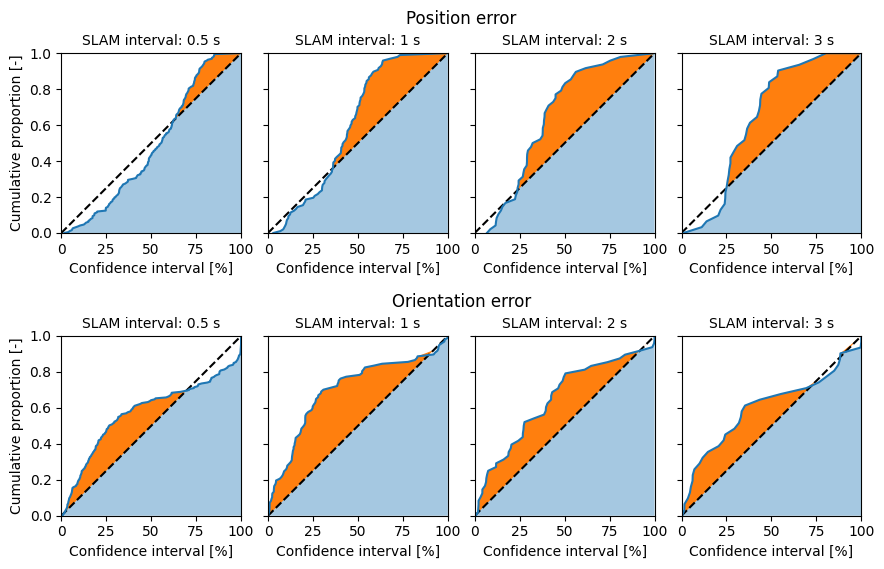

In [58]:
### Calculate the position (xy) confidence interval

# fig = plt.figure(figsize=(12, 6))
fig = plt.figure(figsize=(8, 5.6))
subfig1, subfig2 = fig.subfigures(2, 1, hspace=0.02)
axs1 = subfig1.subplots(1, 4)
axs2 = subfig2.subplots(1, 4)

subfig1.suptitle("Position error")
subfig2.suptitle("Orientation error")

first = True

for (name, error_df), ax1, ax2 in zip(error_dfs.items(), axs1, axs2):
    xy_conf_intervals = []
    for slam_point, ekf_point, ekf_covar in zip(error_df["slam xy"], error_df["ekf xy"], error_df["ekf xy covar"]):
        z_score = z_score_2D(slam_point, ekf_point, ekf_covar)
        conf_interval = z_score_to_confidence_interval(z_score) * 100
        xy_conf_intervals.append(conf_interval)

    xy_conf_intervals = np.array(xy_conf_intervals)

    yaw_conf_intervals = []
    for slam_yaw, ekf_yaw, ekf_var in zip(error_df["slam yaw"], error_df["ekf yaw"], error_df["ekf yaw var"]):
        z_score = z_score_1D(slam_yaw, ekf_yaw, ekf_var)
        conf_interval = z_score_to_confidence_interval(z_score) * 100
        yaw_conf_intervals.append(conf_interval)

    yaw_conf_intervals = np.array(yaw_conf_intervals)

    update_interval = name[12:][:-4].replace("_", ".")

    plot_conf_intervals_distribution(xy_conf_intervals, ax=ax1, title=f"SLAM interval: {update_interval} s", add_ylabel=first)
    plot_conf_intervals_distribution(yaw_conf_intervals, ax=ax2, title=f"SLAM interval: {update_interval} s", add_ylabel=first)
    first = False
    
plt.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.15, hspace=0)
plt.savefig("pose_estimation_proportions_plot.pdf", bbox_inches="tight")
plt.savefig("pose_estimation_proportions_plot.png", bbox_inches="tight")
plt.show()


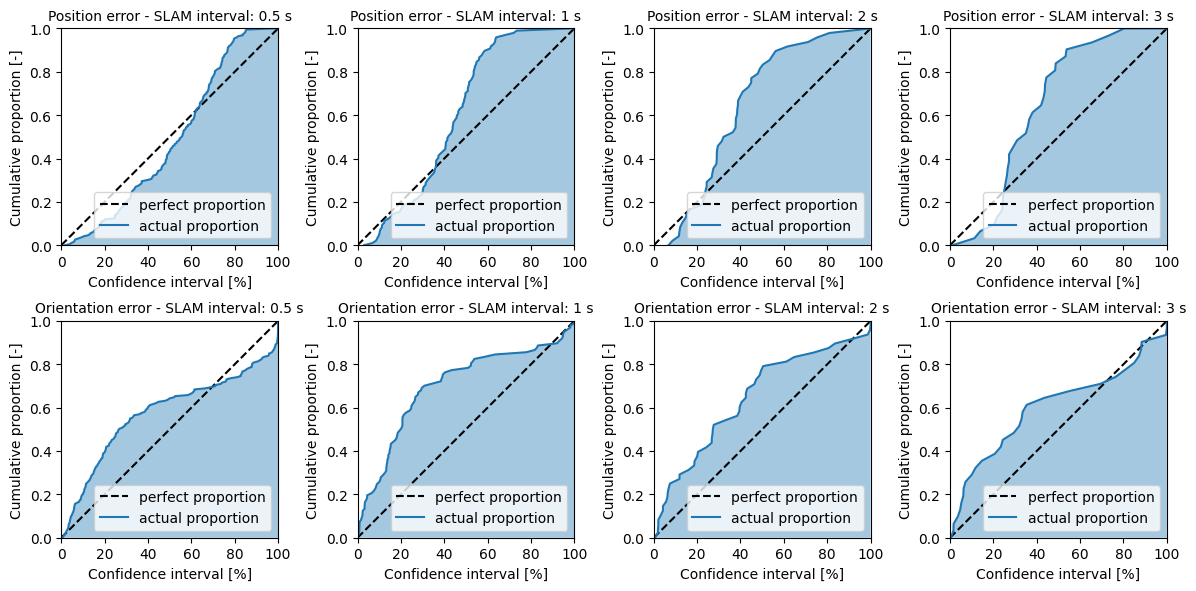

In [120]:
### Calculate the position (xy) confidence interval

fig, axs = plt.subplots(2, 4, figsize=(12, 6))

first = True
for (name, error_df), (ax1, ax2) in zip(error_dfs.items(), axs.T):
    xy_conf_intervals = []
    for slam_point, ekf_point, ekf_covar in zip(error_df["slam xy"], error_df["ekf xy"], error_df["ekf xy covar"]):
        z_score = z_score_2D(slam_point, ekf_point, ekf_covar)
        conf_interval = z_score_to_confidence_interval(z_score) * 100
        xy_conf_intervals.append(conf_interval)

    xy_conf_intervals = np.array(xy_conf_intervals)

    yaw_conf_intervals = []
    for slam_yaw, ekf_yaw, ekf_var in zip(error_df["slam yaw"], error_df["ekf yaw"], error_df["ekf yaw var"]):
        z_score = z_score_1D(slam_yaw, ekf_yaw, ekf_var)
        conf_interval = z_score_to_confidence_interval(z_score) * 100
        yaw_conf_intervals.append(conf_interval)

    yaw_conf_intervals = np.array(yaw_conf_intervals)

    update_interval = name[12:][:-4].replace("_", ".")

    plot_conf_intervals_distribution(xy_conf_intervals, ax=ax1, title=f"Position error - SLAM interval: {update_interval} s")
    plot_conf_intervals_distribution(yaw_conf_intervals, ax=ax2, title=f"Orientation error - SLAM interval: {update_interval} s")
    first = False

plt.tight_layout()
plt.show()


### Extra: SLAM uncertainty influence